Problem Statement: This project will perform sentimental analysis on tweets extracted using twitter api. Only 2 labels are included: positive and negative. We will focus on the hyperparameter tuning of bidirectional LSTM layer and model architecture to observe the effects on the resulting model's accuracy. Hyperparameter tunning includes the number of hiddens layers, number of neurons in dense layer, dropout value, loss functions used and etc.

datasource url: https://www.kaggle.com/datasets/kazanova/sentiment140

Sentiment analysis uses text analysis techniques to interpret and categorise emotions (positive, negative, and neutral) in text data. Companies can determine how the general public feels about particular terms or topics by using sentiment analysis.

There are 1.6M tweets in the dataset. In order to reduce the training time, we resize it to 100,000 data.

ref
https://www.kaggle.com/code/stoicstatic/twitter-sentiment-analysis-using-word2vec-bilstm

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Import Library

In [ ]:
import pandas as pd
import re
import numpy as np
from sklearn.utils import resample
import matplotlib.pyplot as plt

In [ ]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Bidirectional, GlobalMaxPool1D, Dense, LSTM, Conv1D, Embedding

In [ ]:
path = "/content/drive/My Drive/sentiment.csv"
path2 = "/content/drive/My Drive/contractions.csv"

In [ ]:
DATASET_COLUMNS  = ["sentiment", "ids", "date", "flag", "user", "text"]
DATASET_ENCODING = "ISO-8859-1"
dataset = pd.read_csv(path,encoding=DATASET_ENCODING, names=DATASET_COLUMNS)
dataset.head()

,sentiment,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [ ]:
# Removing the unnecessary columns.
dataset = dataset[['sentiment','text']]

# Replacing the values. "0": Negative, "1": Positive
dataset['sentiment'] = dataset['sentiment'].replace(4,1)

<ipython-input-12-62c98f2695f7>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['sentiment'] = dataset['sentiment'].replace(4,1)


In [ ]:
# Resample the dataset to 100000
dataset = resample(dataset, n_samples=100000, random_state=42)

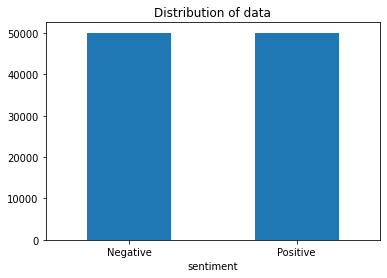

In [ ]:
# Check the distribution of data, It is a balanced dataset
ax = dataset.groupby('sentiment').count().plot(kind='bar', title='Distribution of data',legend=False)
ax = ax.set_xticklabels(['Negative','Positive'], rotation=0)

In [ ]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 121958 to 1488031
Data columns (total 2 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   sentiment  100000 non-null  int64 
 1   text       100000 non-null  object
dtypes: int64(1), object(1)
memory usage: 2.3+ MB


#Data Preprocessing

In [ ]:
# Read contractions.csv and store it as a dictionary.
contractions = pd.read_csv(path2, index_col='Contraction')
contractions.index = contractions.index.str.lower()
contractions.Meaning = contractions.Meaning.str.lower()
contractions_dict = contractions.to_dict()['Meaning']

# Regex Patterns
urlPattern        = r"((http://)[^ ]*|(https://)[^ ]*|(www\.)[^ ]*)"
userPattern       = '@[^\s]+'
hashtagPattern    = '#[^\s]+'
alphaPattern      = "[^a-z0-9<>]"
sequencePattern   = r"(.)\1\1+"
seqReplacePattern = r"\1\1"

# Emoji in Regex
smileemoji        = r"[8:=;]['`\-]?[)d]+"
sademoji          = r"[8:=;]['`\-]?\(+"
neutralemoji      = r"[8:=;]['`\-]?[\/|l*]"
lolemoji          = r"[8:=;]['`\-]?p+"

def preprocessing(tweet):

    tweet = tweet.lower()

    # Replace URls
    tweet = re.sub(urlPattern,'<url>',tweet)
    
    # Replace username to user
    tweet = re.sub(userPattern,'<user>', tweet)
    
    # Replace three or more consecutive letters by two letters
    tweet = re.sub(sequencePattern, seqReplacePattern, tweet)

    # Replace emojis
    tweet = re.sub(r'<3', '<heart>', tweet)
    tweet = re.sub(smileemoji, '<smile>', tweet)
    tweet = re.sub(sademoji, '<sadface>', tweet)
    tweet = re.sub(neutralemoji, '<neutralface>', tweet)
    tweet = re.sub(lolemoji, '<lolface>', tweet)

    for contraction, replacement in contractions_dict.items():
        tweet = tweet.replace(contraction, replacement)

    # Remove non-alphanumeric and symbols
    tweet = re.sub(alphaPattern, ' ', tweet)

    # Adding space on either side of '/' to seperate words (After replacing URLS).
    tweet = re.sub(r'/', ' / ', tweet)
    return tweet

In [ ]:
dataset['cleaned_text'] = dataset.text.apply(preprocessing)

# Data Spliting

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X_data, y_data = np.array(dataset['cleaned_text']), np.array(dataset['sentiment'])

X_train, X_test, y_train, y_test = train_test_split(X_data, y_data,
                                                    test_size = 0.05, random_state = 0)

#Create Word Embeddings

In [ ]:
from gensim.models import Word2Vec

Embedding_dimensions = 100

# Creating Word2Vec training dataset
Word2vec_train_data = list(map(lambda x: x.split(), X_train))

In [ ]:
# Define word2vec model
word2vec_model = Word2Vec(Word2vec_train_data,
                 workers= 8,
                 min_count= 5)

#Tokenization

In [ ]:
# Defining model input length
input_length = 60

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
vocab_length = 60000

tokenizer = Tokenizer(filters="", lower=False, oov_token="<oov>")
tokenizer.fit_on_texts(X_data)
tokenizer.num_words = vocab_length

In [ ]:
X_train = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=input_length)
X_test  = pad_sequences(tokenizer.texts_to_sequences(X_test) , maxlen=input_length)

print("X_train.shape:", X_train.shape)
print("X_test.shape :", X_test.shape)

X_train.shape: (95000, 60)
X_test.shape : (5000, 60)


#Create Embedding Matrix

In [ ]:
embedding_matrix = np.zeros((vocab_length, Embedding_dimensions))

for word, token in tokenizer.word_index.items():
    if word2vec_model.wv.__contains__(word):
        embedding_matrix[token] = word2vec_model.wv.__getitem__(word)

print("Embedding Matrix Shape:", embedding_matrix.shape)

Embedding Matrix Shape: (60000, 100)


# Model 1

###LSTM: 100 neurons, Dropout = 0.3, Batch size: 128, Epoch: 10

In [ ]:
def Model():
    embedding_layer = Embedding(input_dim = vocab_length,
                                output_dim = Embedding_dimensions,
                                weights=[embedding_matrix],
                                input_length=input_length,
                                trainable=False)

    model = Sequential([
        embedding_layer,
        Bidirectional(LSTM(100, dropout=0.3, return_sequences=True)),
        Bidirectional(LSTM(100, dropout=0.3, return_sequences=True)),
        Conv1D(100, 5, activation='relu'),
        GlobalMaxPool1D(),
        Dense(16, activation='relu'),
        Dense(1, activation='sigmoid'),
    ],
    name="Sentiment_Model")
    return model

In [ ]:
training_model = Model()
training_model.summary()

Model: "Sentiment_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 60, 100)           6000000   
                                                                 
 bidirectional_2 (Bidirectio  (None, 60, 200)          160800    
 nal)                                                            
                                                                 
 bidirectional_3 (Bidirectio  (None, 60, 200)          240800    
 nal)                                                            
                                                                 
 conv1d_1 (Conv1D)           (None, 56, 100)           100100    
                                                                 
 global_max_pooling1d_1 (Glo  (None, 100)              0         
 balMaxPooling1D)                                                
                                                   

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

callbacks = [ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
             EarlyStopping(monitor='val_accuracy', min_delta=1e-4, patience=5)]

In [ ]:
training_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
fit_model = training_model.fit(
    X_train, y_train,
    batch_size=128,
    epochs=10,
    validation_split=0.1,
    callbacks=callbacks,
    verbose=1,
)

Epoch 1/10
668/668 [==============================] - 711s 1s/step - loss: 0.5316 - accuracy: 0.7320 - val_loss: 0.4962 - val_accuracy: 0.7559 - lr: 0.0010
Epoch 2/10
668/668 [==============================] - 697s 1s/step - loss: 0.4883 - accuracy: 0.7608 - val_loss: 0.4709 - val_accuracy: 0.7734 - lr: 0.0010
Epoch 3/10
668/668 [==============================] - 693s 1s/step - loss: 0.4700 - accuracy: 0.7738 - val_loss: 0.4716 - val_accuracy: 0.7767 - lr: 0.0010
Epoch 4/10
668/668 [==============================] - 697s 1s/step - loss: 0.4564 - accuracy: 0.7832 - val_loss: 0.4530 - val_accuracy: 0.7873 - lr: 0.0010
Epoch 5/10
668/668 [==============================] - 707s 1s/step - loss: 0.4454 - accuracy: 0.7872 - val_loss: 0.4482 - val_accuracy: 0.7856 - lr: 0.0010
Epoch 6/10
668/668 [==============================] - 710s 1s/step - loss: 0.4343 - accuracy: 0.7949 - val_loss: 0.4460 - val_accuracy: 0.7905 - lr: 0.0010
Epoch 7/10
668/668 [==============================] - 755s 1s/st

In [ ]:
score_1 = training_model.evaluate(X_train, y_train, verbose=1)
score_1

2969/2969 [==============================] - 340s 114ms/step - loss: 0.3542 - accuracy: 0.8414


[0.35415852069854736, 0.841378927230835]

In [ ]:
print("Train Loss:", score_1[0])
print("Train Accuracy:", score_1[1])

Train Loss: 0.35415852069854736
Train Accuracy: 0.841378927230835


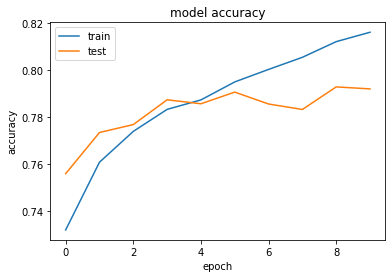

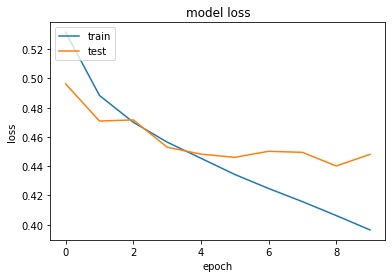

In [ ]:
plt.plot(fit_model.history['accuracy'])
plt.plot(fit_model.history['val_accuracy'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(fit_model.history['loss'])
plt.plot(fit_model.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

def ConfusionMatrix(y_pred, y_test):
    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(y_test, y_pred)

    categories  = ['Negative','Positive']
    group_names = ['TN','FP', 'FN','TP']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

    labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
                xticklabels = categories, yticklabels = categories)

    plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

157/157 [==============================] - 19s 105ms/step


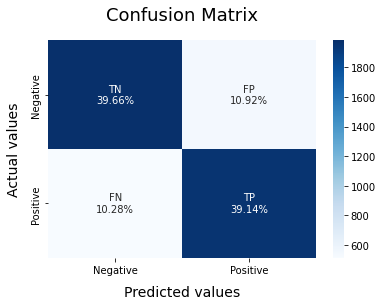

In [ ]:
# Predicting on the Test dataset
y_pred = training_model.predict(X_test)

# Converting prediction to reflect the sentiment predicted
y_pred = np.where(y_pred>=0.5, 1, 0)

# Evaluation metrics
ConfusionMatrix(y_pred, y_test)

In [ ]:
# Evaluation metrics
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.76      0.85      0.80      2529
           1       0.82      0.73      0.77      2471

    accuracy                           0.79      5000
   macro avg       0.79      0.79      0.79      5000
weighted avg       0.79      0.79      0.79      5000



# Model 3

LSTM (add one more dense layer): 100 neurons, Dropout = 0.3, Batch size: 128, Epoch: 10

In [ ]:
def Model3():
    embedding_layer = Embedding(input_dim = vocab_length,
                                output_dim = Embedding_dimensions,
                                weights=[embedding_matrix],
                                input_length=input_length,
                                trainable=False)

    model = Sequential([
        embedding_layer,
        Bidirectional(LSTM(100, dropout=0.3, return_sequences=True)),
        Conv1D(100, 5, activation='relu'),
        GlobalMaxPool1D(),
        Dense(32, activation='relu'),
        Dense(16, activation='relu'),
        Dense(1, activation='sigmoid'),
    ],
    name="Sentiment_Model")
    return model

In [ ]:
training_model = Model3()
training_model.summary()

Model: "Sentiment_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 60, 100)           6000000   
                                                                 
 bidirectional_4 (Bidirectio  (None, 60, 200)          160800    
 nal)                                                            
                                                                 
 conv1d_2 (Conv1D)           (None, 56, 100)           100100    
                                                                 
 global_max_pooling1d_2 (Glo  (None, 100)              0         
 balMaxPooling1D)                                                
                                                                 
 dense_4 (Dense)             (None, 32)                3232      
                                                                 
 dense_5 (Dense)             (None, 16)            

In [ ]:
training_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
fit_model = training_model.fit(
    X_train, y_train,
    batch_size=128,
    epochs=10,
    validation_split=0.1,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/10
668/668 [==============================] - 361s 534ms/step - loss: 0.5277 - accuracy: 0.7353 - val_loss: 0.4876 - val_accuracy: 0.7638 - lr: 0.0010
Epoch 2/10
668/668 [==============================] - 353s 528ms/step - loss: 0.4834 - accuracy: 0.7664 - val_loss: 0.4700 - val_accuracy: 0.7767 - lr: 0.0010
Epoch 3/10
668/668 [==============================] - 352s 527ms/step - loss: 0.4620 - accuracy: 0.7781 - val_loss: 0.4597 - val_accuracy: 0.7769 - lr: 0.0010
Epoch 4/10
668/668 [==============================] - 355s 531ms/step - loss: 0.4457 - accuracy: 0.7895 - val_loss: 0.4573 - val_accuracy: 0.7838 - lr: 0.0010
Epoch 5/10
668/668 [==============================] - 351s 526ms/step - loss: 0.4306 - accuracy: 0.7982 - val_loss: 0.4602 - val_accuracy: 0.7864 - lr: 0.0010
Epoch 6/10
668/668 [==============================] - 355s 532ms/step - loss: 0.4150 - accuracy: 0.8067 - val_loss: 0.4534 - val_accuracy: 0.7871 - lr: 0.0010
Epoch 7/10
668/668 [==========================

In [ ]:
score_2 = training_model.evaluate(X_train, y_train, verbose=1)
print("Train Loss:", score_2[0])
print("Train Accuracy:", score_2[1])

2969/2969 [==============================] - 144s 49ms/step - loss: 0.2988 - accuracy: 0.8746
Train Loss: 0.29878392815589905
Train Accuracy: 0.8746421337127686


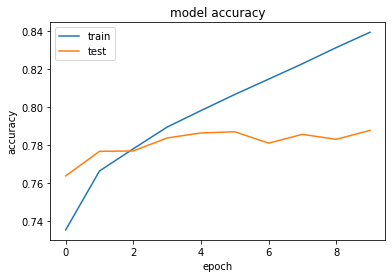

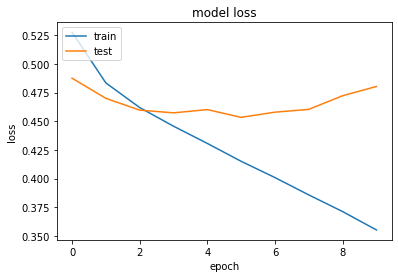

In [ ]:
plt.plot(fit_model.history['accuracy'])
plt.plot(fit_model.history['val_accuracy'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(fit_model.history['loss'])
plt.plot(fit_model.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

# Summary